# Analisis de Emisiones de CO2 provenientes de la generacion de Electricidad en Argentina

**Contexto empresarial.** Imaginemos que me desarrollo como analista en YPF, una empresa de energía que participa activamente en la generación de electricidad en Argentina. Me han asignado un proyecto en el que debo utilizar datos históricos de emisiones de dióxido de carbono (CO2) de Our World in Data y datos de generación de electricidad por tipo de combustible y por fuente de generación en Argentina a lo largo del tiempo. El objetivo del proyecto es proyectar las emisiones de CO2 provenientes de la generación de electricidad en Argentina para los próximos años.

La empresa está interesada en conocer la evolución de las emisiones de dióxido de carbono en la generación de electricidad en el país, ya que esto le permitirá anticipar la demanda de energía y planificar su estrategia de producción para cumplir con las regulaciones ambientales y satisfacer la creciente demanda energética de los hogares y empresas en Argentina.

**Problema comercial.** Como analista de datos, mi objetivo es utilizar las fuentes de datos disponibles para desarrollar modelos precisos que permitan proyectar las emisiones de CO2 de la generación de electricidad en Argentina para los próximos años. A partir de estos modelos, podré identificar las tendencias históricas y futuras de las emisiones de CO2, lo que permitirá a YPF planificar sus operaciones de generación de energía de manera más efectiva y sostenible.

**Contexto analítico.** Tenemos estas tres fuentes de informacion:

**1.** El archivo "owid-co2-data" contiene datos y metricas relacionados a emisiones de CO2 y de otros gases de efecto invernadero, energia, para todos los paises del mundo.

**2.** El archivo "Oferta Total Horaria.xlsx" contiene el historial de oferta electrica pen argentina por fuente de generacion (renovables, nuclear, gas, petroleo o carbon).

**3.** El archivo "Combustibles Mensual.xlsx" contiene el historial de los combustibles usados en cada momento del tiempo para la generacion de energia electrica.

In [96]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly
import plotly.express as px
import statsmodels
import plotly.graph_objects as go

**-----------------------------------------------------------------------------------------------------------------------**
## Analisis exploratorio del dataset owid-co2-data: emisiones de CO2 en el mundo

En este primer dataset detallan datos sobre emisiones de gases de efecto invernadero a nivel mundial. A partir de este dataset pude responder las siguientres preguntas:
1. Que paises son los que mas contribuyeron en perspectiva historica al acumulado de emisiones de CO2 actual.
2. Como se relaciona el nivel de emisiones con el Producto Bruto y con la Poblacion para este mix de paises
3. Como se distribuyen las emisiones segun deciles de GDP? 

Luego me enfoco en Argentina y respondemos a las siguientes preguntas:
1. Como evolucionaron las emisiones de Argentina hasta la actualidad?
2. Como se componen estas emisiones segun el tipo de combustible o industria en cada momento del tiempo?
3. Cual es el combustible que mas contribuyo a las emisiones de co2 acumuladas?

In [97]:
#Cargo df sobre emisiones owid-co2-data
raw=pd.read_excel(r"C:\Users\Bruno\Desktop\Curso Data Science\Dataframes\owid-co2-data.xlsx")
raw

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.121,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3769828.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.118,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3787706.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.116,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3806634.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.115,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3825655.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.114,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46518,Zimbabwe,2017,ZWE,14751101.0,2.194784e+10,0.469,0.032,9.596,-0.937,-8.899,...,NaN,0.0,0.0,0.219,0.026,NaN,115.59,28.30,0.910,9.486
46519,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,0.558,0.037,11.795,2.199,22.920,...,NaN,0.0,0.0,0.211,0.033,NaN,118.22,30.83,0.771,6.537
46520,Zimbabwe,2019,ZWE,15354606.0,NaN,0.570,0.037,11.115,-0.681,-5.772,...,NaN,0.0,0.0,0.183,0.030,NaN,117.96,30.53,0.978,8.795
46521,Zimbabwe,2020,ZWE,15669663.0,NaN,0.570,0.036,10.608,-0.507,-4.559,...,NaN,0.0,0.0,0.194,0.030,NaN,NaN,NaN,1.006,9.481


Antes de comenzar el analisis vemos que variables me interesan y cuales de ellas tienen datos faltantes. Identifico que:
- Hay 46523 filas
- La variable con codigos ISO solo tiene 39862 datos no nulos, lo que se debe a la presencia de agrupamientos en la variable country que no tienen codigos ISO (Union Europea, etc)

Y las variables de interes son: 

- **Country**: pais en el q se generan las emisiones
- **GDP**: Producto Interno Bruto (PIB) medido en dólares internacionales (internacional-$) utilizando precios de 2011 para ajustar por los cambios de precios a lo largo del tiempo (inflación) y las diferencias de precios entre los países. Se calcula multiplicando el PIB per cápita por la población.
- **cumulative_co2**: emisiones totales acumuladas de dióxido de carbono (CO₂) basadas en la producción, excluyendo el cambio de uso del suelo en millones de toneladas. No tienen en cuenta las emisiones incorporadas en bienes comerciados
- **population**: poblacion.
- **co2**: número anual total de emisiones basadas en la producción de dióxido de carbono (CO₂), excluyendo los cambios de uso del suelo, medidos en millones de toneladas.
- **coal_co2**: emisiones acumuladas de co2 provenientes del carbon
- **flaring_co2**: emisiones acumuladas de co2 provenientes de la quema
- **gas_co2**: emisiones acumuladas de co2 provenientes del gas
- **oil_co2**: emisiones acumuladas de co2 provenientes del petroleo
- **other_industry_co2**: emisiones acumuladas de co2 provenientes de otra industria (Ourworldindata)
- **cement_co2**: emisiones acumuladas de co2 provenientes del cemento

In [98]:
#raw.info()

In [99]:
raw.describe()
raw.describe(include="object")

,country,iso_code
count,46523,39862
unique,269,232
top,South America,REU
freq,272,272


En base a esto, dado que tenemos un panel de datos, la correccion por datos nulos debe tener en cuenta el pais (**country**) y el año (**year**). Antes de eso me quedo solo con las variables que me interesan para el analisis.

In [100]:
#me quedo con las var mas relevantes
raw = raw[['country','iso_code','gdp','year','cumulative_coal_co2','cumulative_flaring_co2','cumulative_gas_co2',
           'cumulative_luc_co2','cumulative_oil_co2','cumulative_other_co2','cumulative_cement_co2','cumulative_co2', 
           'population', 'co2', 'coal_co2','flaring_co2', 'gas_co2', 'oil_co2','other_industry_co2', 'cement_co2']]

df_procesado = raw.copy()

df_procesado = df_procesado.dropna(subset=['iso_code'])
df_procesado = df_procesado.rename(columns={"iso_code": "country_1"})
df_procesado = df_procesado.dropna(subset=['country_1'], axis=0, inplace=False)

# ordeno los datos por país y año
df_procesado = df_procesado.sort_values(['country', 'year'])

In [101]:
# interpolo los valores faltantes de las variables seleccionadas
vars_to_interpolate = ['cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 
                       'cumulative_oil_co2', 'cumulative_other_co2', 'cumulative_co2', 'population', 'co2', 'coal_co2',
                       'flaring_co2', 'gas_co2', 'oil_co2', 'other_industry_co2', 'cement_co2', 'gdp']
"""
group_cols = ['country', 'year']
df_procesado[vars_to_interpolate] = df_procesado.groupby(group_cols)[vars_to_interpolate].apply(lambda group: group.interpolate(method='nearest'))
"""

# Ahora relleno los valores faltantes con el último valor válido para cada país a partir de 2018
df_procesado.loc[df_procesado['year'] >= 2018, vars_to_interpolate] = df_procesado.loc[df_procesado['year'] >= 2018].groupby('country')[vars_to_interpolate].fillna(method='ffill')

df_procesado = df_procesado.sort_values(['year', 'country'])

Voy a simplificar la base, quedarme solo con los paises que mas representen en el total acumulado de emisiones + Argentina, de esta manera, voy a poder simplificar el df sin perder informacion relevante.

Segun Our Wolrd in Data los principales emisores son:
1. China
2. Estados Unidos
3. Paises de la Union Europea (en conjunto)
4. India
5. Canada
6. Brasil
7. Paises del sur de Africa (en conjunto)
8. Reino Unido

A esto voy a agregar Argentina y al resto de paises los agrupo en "Resto".

In [102]:
import pycountry

# Códigos ISO de los países de la UE y del sur de Africa
eu_countries = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE']
eu_country_codes = [pycountry.countries.get(alpha_2=i).alpha_3 for i in eu_countries]
sa_countries = ['ZAF', 'BWA', 'LSO', 'NAM', 'SWZ']
resttop_countries = {'CHN', 'USA', 'IND', 'CAN', 'BRA', 'ZAF', 'GBR', 'ARG'}

# Diccionario que asocie cada país con su grupo
country_groups = {}
for country in pycountry.countries:
    if country.alpha_2 in eu_countries:
        country_groups[country.name] = 'EU'
    elif country.alpha_3 in sa_countries:
        country_groups[country.name] = 'SA'
    elif country.alpha_3 in resttop_countries:
        country_groups[country.name] = country.alpha_3
    else: 
        country_groups[country.name] = 'Resto'

# Columna con el grupo de cada país
df_procesado['country_2'] = df_procesado['country'].map(country_groups)

# Dataframe editable, seteo el indice temporal
graficos_df=df_procesado.copy()
graficos_df['year'] = pd.to_datetime(graficos_df['year'], format='%Y')
graficos_df.set_index('year', inplace=True)

my_colors = my_colors = px.colors.sequential.Turbo

La variable de mayor interes o "target" en este caso es la variable CO2, que tiene las emisiones de CO2 año a año por pais. Si seleccionamos un año, por ejemplo 2021 (ya que tenemos datos de panel) vemos que los datos tienen alta dispersion (histograma) por lo que podemos agrupar por los primeros 10 emisores. Si consideramos outliers la distribucion de co2 se encuentra entre 0 y +10.000 M toneladas, al quitarlos el maximo y minimo del target esta entre 0 y 140 M toneladas.

La media de se encunetra en torno a las 20 Millones de toneladas anuales.

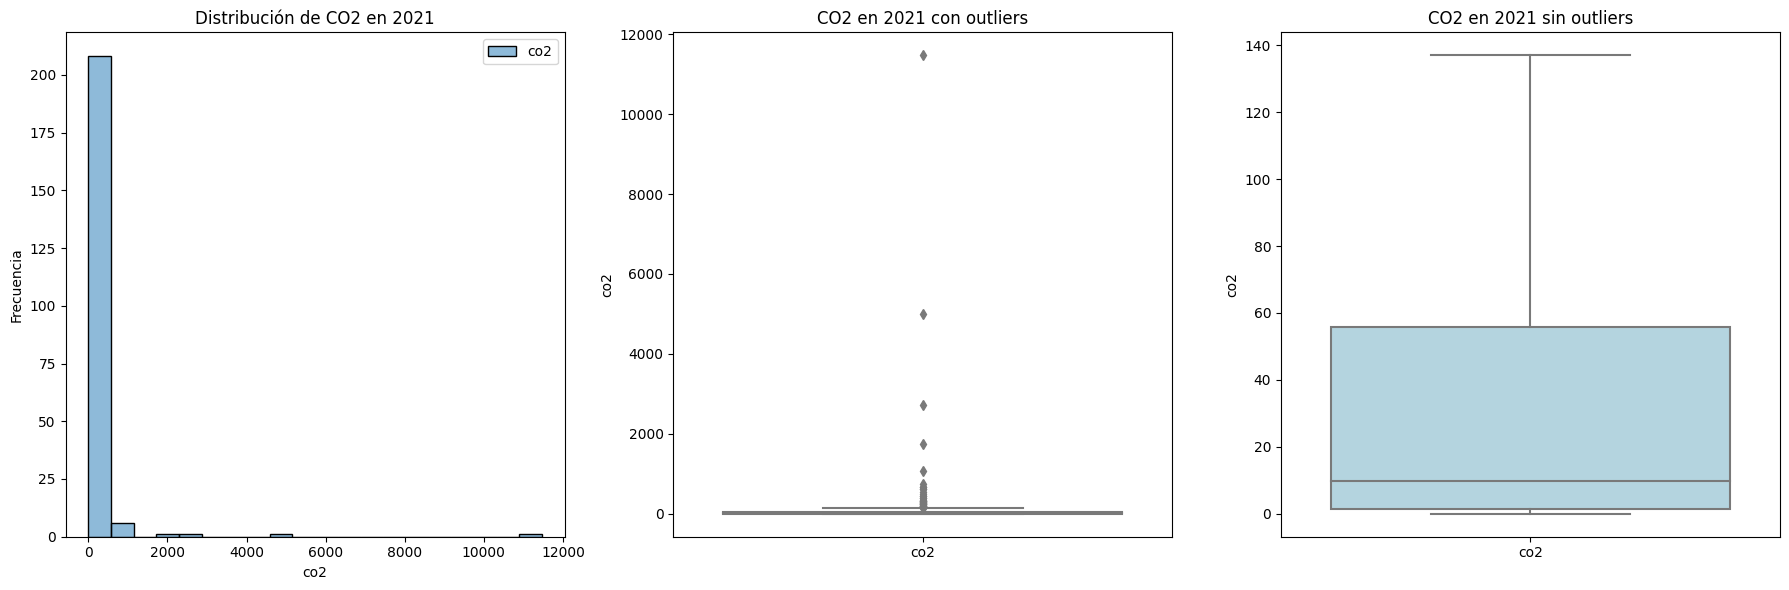

In [103]:
subset2021 = df_procesado[df_procesado['year'] == 2021].dropna(subset=['co2'])[['co2']]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 6))

sns.histplot(data=subset2021, ax=ax1, bins=20)
ax1.set_title('Distribución de CO2 en 2021')
ax1.set_xlabel('co2')
ax1.set_ylabel('Frecuencia')

#con outliers
sns.boxplot(data=subset2021, ax=ax2, color='lightblue')
ax2.set_title('CO2 en 2021 con outliers')
ax2.set_ylabel('co2')

#sin outliers
sns.boxplot(data=subset2021, ax=ax3, color='lightblue', showfliers=False)
ax3.set_title('CO2 en 2021 sin outliers')
ax3.set_ylabel('co2')

plt.tight_layout()
plt.show()

Ahora podemos ver las emisiones de CO2 por pais, por simplicidad solo se muestran los 5 mayores y menores emisores. El mayor emisor es Estados Unidos, y las menores emisiones se encunetran en la Antartida.

In [104]:
tabla_df = df_procesado.dropna(subset=['co2'])
tabla = pd.pivot_table(tabla_df, values='co2', index='country', aggfunc=np.sum)

tabla_sorted = tabla.sort_values('co2', ascending=False)
top_5_mayores = tabla_sorted.head(5)
top_5_menores = tabla_sorted.tail(5)

tabla_final = pd.concat([top_5_mayores, top_5_menores])
tabla_styled = tabla_final.style.apply(lambda x: ['background-color: red' if v == tabla_final['co2'].min() or v == tabla_final['co2'].max() else '' for v in x], axis=1)
tabla_styled


,co2
country,
United States,421906.853000
China,249352.817000
Russia,117547.633000
Germany,93290.506000
United Kingdom,78508.722000
Saint Helena,0.402000
Niue,0.305000
Tuvalu,0.283000
Puerto Rico,0.209000


Voy a empezar describiendo la situacion sobre emisiones de CO2 a nivel mundial en el contexto actual. 

**Que paises son los q mas aportaron a lo largo del tiempo a las emisiones acumuladas de CO2?**

A partir del primer grafico podemos ver que los primeros 10 emisores son las principales economias del mundo en terminos de su producto bruto o poblacion.

In [105]:
subset_2021 = graficos_df.copy()
subset_2021 = subset_2021.loc['2021-01-01':]

# Agrupo por país y sumo las emisiones acumuladas
df_grouped = subset_2021.groupby('country_2')['cumulative_co2'].sum()

# dataframe para Plotly
df = pd.DataFrame({'country_2': df_grouped.index, 'cumulative_co2': df_grouped.values})

# valores para el treemap
df['size'] = df['cumulative_co2']/df['cumulative_co2'].sum()

# labels para los treemap
df['label'] = df['country_2'].astype(str) + '<br>' + df['cumulative_co2'].astype(str) + ' ktCO2'

fig = px.treemap(df, 
                 path=['country_2'], 
                 values='size', 
                 color='country_2',
                 hover_data=['label'],
                 color_discrete_sequence= my_colors,
                 template="simple_white"
                )

# actualizar el título del gráfico
fig.update_layout(
    title={
        'text': "Quien contribuye mas a las emisiones acumuladas de CO2?",
        'x': 0.5,
        'y': 0.96,
        'font': {'size': 18, 'color': 'black', 'family': 'Arial, sans-serif'},
        'xanchor': 'right',
    },
    annotations=[
        dict(
            x=0,
            y=0.959,
            showarrow=False,
            text="<i style='font-size:12px;'> Primeros 10 paises (region) segun emisiones acumuladas de CO2 a 2021, en millones de toneladas. Las emisiones acumuladas <br> son la suma continua de emisiones de CO₂ producidas a partir de combustibles fósiles e industria desde 1750 .</i>",
            xref='paper',
            yref='paper',
            font= {'size': 12, 'color': 'black', 'family': 'Arial'},
            xanchor='left',
            yanchor='bottom',
            align='left'
        )
    ]
)



# actualizar las etiquetas
fig.update_traces(hovertemplate='<b>%{label}</b><br>Emisiones acumuladas de CO2 (como % del total): %{value:.2%}')
fig.show()

Entonces... 

**Que tipo de relacion (+/-) hay entre el CO2 y poblacion/ingreso?**

Para esto veo dos cosas: relacion del ingreso hoy (GDP) y la poblacion con las emisiones de co2 actuales (no acumuladas).

**Antes de tratar datos faltantes:** Como podemos ver, la relacion es positiva en ambos casos, pero pareceria q a priori hay una mayor relacion entre poblacion y co2 que entre gdp y co2. Aca puede estar sucediendo que al considerar unicamente las emisiones de co2 y no las totales de efecto invernadero nos estemos perdiendo informacion. 

**Luego de tratar datos faltantes:** la relacion entre gpd y co2 parece ser mas fuerte que con poblacion. Aca se ve algo importante, que es que si bien los paises con mayor poblacion tienen mas emisiones por la simple razon de que mas personas emiten mas, hay paises dado su nivel de gdp tienen emisiones per capita mas altas. Esto nos quiere decir que los habitantes de personas en paises de menor desarrollo relativo


In [106]:
subset_0515 = graficos_df.loc['2018-01-01']
subset_0515['population_M'] = subset_0515['population'] / 1000000
subset_0515['gdp_pc'] = subset_0515['gdp'] / subset_0515['population']
subset_0515['co2_pc'] = subset_0515['co2'] / subset_0515['population']

# Grafico 1: GDP vs CO2
q_low = subset_0515["co2_pc"].quantile(0.01)
q_hi  = subset_0515["co2_pc"].quantile(0.99)
graf1 = subset_0515[(subset_0515["co2_pc"] < q_hi) & (subset_0515["co2_pc"] > q_low)]

# Grafico 1: GDP vs CO2
fig1 = px.scatter(graf1, x="gdp_pc", y="co2_pc",
                  labels={"co2_pc": "Emisiones de CO2 per capita", "gdp_pc": "PIB per cápita ($)"},
                  template="simple_white",
                  color="country",
                  color_discrete_sequence= my_colors)

# estilo de la figura
fig1.update_traces(marker=dict(size=10, opacity=0.5),
                   selector=dict(mode='markers'))

# gráfico 2: Poblacion y CO2
q_low = subset_0515["population_M"].quantile(0.01)
q_hi  = subset_0515["population_M"].quantile(0.99)
graf2 = subset_0515[(subset_0515["population_M"] < q_hi) & (subset_0515["population_M"] > q_low)]

fig2 = px.scatter(graf2, x="population_M", y="co2",
                  labels={"co2": "Emisiones de CO2 (kt)", "population_M": "Población (millones)"},
                  template="simple_white",
                  color="country",
                  color_discrete_sequence= my_colors)

# estilo de la figura
fig2.update_traces(marker=dict(size=10, opacity=0.5),
                   selector=dict(mode='markers'))

fig1.update_layout(
    height=400,
    width=900,
    title={
    'text': "Como se relaciona el nivel de GDP per capita con las emisiones de CO2?",
    'y':0.95,
    'x':0.70,
    'xanchor': 'right',
    'yanchor': 'top',
    'font': {'size': 18, 'color': '#000000', 'family': 'Arial'}
})

fig2.update_layout(
    height=400,
    width=900,
    title={
    'text': "Y con la poblacion?",
    'y':0.95,
    'x':0.20,
    'xanchor': 'right',
    'yanchor': 'top',
    'font': {'size': 18, 'color': '#000000', 'family': 'Arial'}
})


# Mostrar la figura
fig1.show()
fig2.show()


C:\Users\Bruno\AppData\Local\Temp\ipykernel_800\684655188.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bruno\AppData\Local\Temp\ipykernel_800\684655188.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bruno\AppData\Local\Temp\ipykernel_800\684655188.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

### Como ingresa argentina en este contexto?

Argentina es un pais de ingreso per capita elevado, decil 9, pero dentro de su decil se encuentra por debajo del promedio de emisiones per capita.

In [107]:
# deciles según la variable GDP
subset_0515['gdp_deciles'] = pd.qcut(subset_0515['gdp'], 10, labels=False)

# gráfico de cajas y bigotes con Plotly
fig = px.box(subset_0515, x='gdp_deciles', y='co2_pc', 
             title='CO2 per capita según deciles de GDP',
             labels={'gdp_deciles': 'Deciles de GDP', 'co2_pc': 'CO2 per capita'})

fig.update_layout(template='simple_white')

# trazo adicional para Argentina
fig.add_trace(go.Box(
    x=[9],  # Decil correspondiente a Argentina
    y=subset_0515[subset_0515['country'] == 'Argentina']['co2_pc'],  # Emisiones de CO2 per capita de Argentina
    name='Argentina',
    marker=dict(color='red'),
    boxpoints='all',
    jitter=0.3,
    pointpos=-1.8,
    showlegend=False
))

fig.show()


C:\Users\Bruno\AppData\Local\Temp\ipykernel_800\1465751769.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [108]:
#Sub dataset para argentina
grafico3=graficos_df.copy()
grafico3=grafico3[grafico3['country_2']=="ARG"]
grafico3 = grafico3.loc['1920-01-01':]
grafico3=grafico3.reset_index()

**Como evolucionaron en el tiempo las emisiones de co2 de Argentina?**

La variable co2 nos brinda este dato, expresada en millones de ton de CO2. Como vemos, las emisiones de co2 no pararon de crecer desde el incio de la serie, sin embargo vemos un maximo que se alcanza antes de la pandemia. El dato pos pandemia aun no logra sobrepasar las emisiones pre pandemia.

In [109]:
import plotly.express as px

fig = px.line(grafico3, x='year', y='co2', title='Evolucion de las emisiones totales de CO2 en Argentina',
                 color_discrete_sequence= my_colors, template="simple_white")

fig.update_xaxes(title_text='Año')
fig.update_yaxes(title_text='Millones de toneladas de co2')
fig.update_layout(annotations=[
        dict(
            x=0,
            y=1.05,
            showarrow=False,
            text="<i style='font-size:12px;'> Emisiones de dióxido de carbono (CO₂) de combustibles fósiles e industrias. <br> No se incluye el cambio de uso de la tierra. .</i>",
            xref='paper',
            yref='paper',
            font= {'size': 12, 'color': 'black', 'family': 'Arial'},
            xanchor='left',
            yanchor='bottom',
            align='left'
        )
    ],
    title={
        'text': "Evolucion de las emisiones totales de CO2 en Argentina",
        'y':0.96,
        'x':0.5,
        'xanchor': 'right',
        'yanchor': 'top',
        'font': {'size': 18, 'color': '#000000', 'family': 'Arial'}
    },
    template='simple_white'
)

fig.show()


**Que fuente de energia fue la de mayor dinamica?**

Hasta los 2000 el petroleo fue el principal origen de las emisiones. A partir de dicho año el gas comienza a sobrepasarlo como el principal combustible en orden de incidencia año a año, lo que esta directamente relacionado a q es el principal componente de nuestra matriz energetica.

In [110]:
fig = px.area(grafico3, x='year', y=['coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'other_industry_co2', 'cement_co2'],
              title='Emisiones totales de co2 por combustible e industria - Argentina', template="simple_white",
                 color_discrete_sequence= my_colors)
fig.update_layout(xaxis_title='Año', yaxis_title='Millones de toneladas de co2', title_font_size=15)
fig.show()

Sin embargo, a pesar de que vemos un alto crecimeinto a lo largo de todo el periodo, podemos ver que desde los 2000 las emisiones de la mayor parte de los combustibles se encuentan estables, lo que se ve tambien el el siguiende grafico a traves de tasas de variacion. Tengamos en cuenta que en este grafico, las emisiones de cada combustible se encunetran apiladas, por lo que en orden de incidencia viene el oil, gas, cemento, carbon y otros.

A partir de 2010, la estabilidad relativa de las emisiones puede relacionarse a un estancamiento del PIB, veamos que en 2021 hay una fuerte expansion de las emisiones lo que podria relacionarse con la recuperacion economica luego de la caida de la actividad durante 2020.

In [111]:
# Seleccionar las columnas necesarias
df_pct = grafico3[['year', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'cement_co2']].dropna(subset=['cement_co2'])

# Calcular las tasas de variación de cada columna en relación al año anterior
df_pct = df_pct.set_index('year').pct_change().reset_index()

# Graficar las tasas de variación
fig = px.bar(df_pct, x='year', y=['coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'cement_co2'],
             title='Tasas de variación de emisiones de CO2 por año',
             labels={'value': 'Tasa de variación', 'variable': 'Fuente de emisiones'},
             template='simple_white')

# Mostrar el gráfico
fig.show()


Entonces...

Si bien el gas y el petroleo tienen una dinamica similar, **cual es que mas aporto a las emisiones de CO2 acmuladas de Argentina?**

Como podemos ver, a pesar de la dinamica importante que tuvieron las emisiones de gas en los ultimos años, en terminos acumulados aun no han superado al stock de emisiones generadas por el petroleo en Argentina.

In [112]:
fila = grafico3.iloc[-1]
dic = fila.to_dict()
subdic = {k.split('_')[1]: v for k, v in dic.items() if k.startswith('cumulative_')}

labels = list(subdic.keys())
values = list(subdic.values())

df = pd.DataFrame({'labels': labels, 'values': values})
df = df.drop([3, 7])


fig = px.pie(df, values='values', names='labels', 
             title='Composicion de las emisiones acumuladas <br>de Argentina, por tipo de combustible e industria',
             template="simple_white",
                 color_discrete_sequence= my_colors)
fig.update_traces(textposition='inside', textinfo='percent+label', hole=.4)

fig.show()


En resumen, hasta este punto contestamos a estas preguntas:
1. **Que paises son los que mas contribuyeron en perspectiva historica al acumulado de emisiones de CO2 actual**: China, Estados Unidos, paises de la union europea, India, Canada, Brasil, Paises del sur de Africa y Reino Unido,
2. **Como se relaciona el nivel de emisiones con el Producto Bruto y con la Poblacion para este mix de paises**:la relacion entre gpd y co2 parece ser mas fuerte que con poblacion. Aca se ve algo importante, que es que si bien los paises con mayor poblacion tienen mas emisiones por la simple razon de que mas personas emiten mas, hay paises dado su nivel de gdp tienen emisiones per capita mas altas. Esto nos quiere decir que los habitantes de personas en paises de menor desarrollo relativo emiten menos que aquellos en paises mas desarrollados 
3. **Como se distribuyen las emisiones segun deciles de GDP?**: de la mano con el resultado positivo para la relacion entre gdp y emisiones per capita, vemos que a mayor decil de ingreso (gdp) mayor son las emisiones promedio. Es importante notar que tambien se da mayor dispersion de las emisiones en los deciles superiores de la distribucion, hay paises de altos ingresos que emiten por habitante lo mismo que paises del decil 1.

Para Argentina:
1. **Como evolucionaron las emisiones de Argentina hasta la actualidad?** 
Las emisiones de co2 no pararon de crecer desde el incio de la serie, sin embargo vemos un maximo que se alcanza antes de la pandemia. El dato pos pandemia aun no logra sobrepasar las emisiones pre pandemia.
2. **Como se componen estas emisiones segun el tipo de combustible?** 
Hasta los 2000 el petroleo fue el principal origen de las emisiones. A partir de dicho año el gas comienza a sobrepasarlo como el principal combustible en orden de incidencia año a año, lo que esta directamente relacionado a q es el principal componente de nuestra matriz energetica.
3. **Cual es el combustible que mas contribuyo a las emisiones de co2 acumuladas?**
Si bien el gas y el petroleo tienen una dinamica similar, en terminos acumulados el gas aun no ha superado al stock de emisiones generadas por el petroleo en Argentina.

**-----------------------------------------------------------------------------------------------------------------------**
## Construccion del modelo para estimar emisiones de CO2

Voy a incorporar tres data sets: combustibles, contiene el consumo de combustibles mensual por tipo para la generacion de electricidad, emisiones,tiene una estimacion de emisiones hecha por CAMMESA, y VARIABLES_ANUALES, tiene variables que pueden ser relevantes para la proyeccion de las emisiones (demanda electrica, demanda agregada, consumo publico y privado, entre otras). Lo que busco es **desarrollar un modelo preciso que permita proyectar las emisiones de CO2 en la generación de electricidad en Argentina para los próximos años**, lo que permitirá a YPF planificar sus operaciones de generación de energía de manera más efectiva y sostenible.


#### Features de "Combustibles"
- **Fuente de generacion**: fuente de generacion de la electricidad (termica o renovable)
- **Combustible**: tipo de combustible que se usa para generar esa energia (GAS NATURAL(dam3), FUEL OIL(ton), GAS OIL(m3), CARBÓN  MINERAL(ton), BIODIESEL(ton)).

In [113]:
df_combustibles=pd.read_excel(r"C:\Users\Bruno\Desktop\Curso Data Science\Dataframes\Combustibles Mensual.xlsx", sheet_name="combustible")
df_emicontrol=pd.read_excel(r"C:\Users\Bruno\Desktop\Curso Data Science\Dataframes\Combustibles Mensual.xlsx", sheet_name="emisiones")
VARIABLES=pd.read_excel(r"C:\Users\Bruno\Desktop\Curso Data Science\Dataframes\Combustibles Mensual.xlsx", sheet_name="VARIABLES_ANUALES")

In [114]:
#df_emicontrol
df_emicontrol.columns = df_emicontrol.columns.str.lower()
#df_emicontrol['fecha'] = pd.to_datetime(df_emicontrol['fecha'], format='%Y-%m-%d')
df_emicontrol['fecha'] = df_emicontrol['fecha'].dt.year
df_emicontrol = df_emicontrol.groupby(['fecha']).sum().reset_index()

Para calcular las emisiones de CO2 de la generación de electricidad voy a seguir la siguiente fórmula:

**Emisiones de CO2 = Cantidad de combustible consumido x Factor de emisión de CO2 del combustible**

La cantidad de combustible consumido se mide en unidades físicas, como metros cúbicos (m3), toneladas (t) o litros (L), dependiendo del tipo de combustible. El factor de emisión de CO2 del combustible se expresa en unidades de masa de CO2 por unidad de combustible consumido, como kgCO2/m3, tCO2/t o kgCO2/L. En este caso voy a utilizar los FE (factores de emision) en toneladas estimados para Argentina por las secretarias de Energia y Desarrollo Sustentable de la Nacion:

<img src="FF.png">

Por ejemplo, si se quema 1000 m3 de gas natural para generar electricidad y el factor de emisión de CO2 del gas natural es de 1,936 tCO2/dam3, entonces las emisiones de CO2 generadas serían:

- **Emisiones de CO2 = 1000 dam3 x 1,936 tCO2/dam3**
- **Emisiones de CO2 = 1830 tCO2**

Es importante destacar que al considerar solo las emisiones de CO2 se está ignorando la contribución de otros gases de efecto invernadero que pueden ser emitidos durante la producción, transporte y uso del combustible. Por lo tanto, es importante tener en cuenta que la huella de carbono total de la generación de electricidad puede ser mayor que la cantidad de emisiones de CO2 calculada solo a partir del factor de emisión de CO2 del combustible.

CAMMESA presenta una estimacion de las emisiones por tipo de gas, por lo que podemos comprar la estimacion que hice con los datos de cammesa a modo de control.

In [115]:
factores_emision = {
    "C_GAS NATURAL": 1.94819592,
    "C_FUEL OIL": 3.17228090666667,
    "C_GAS OIL": 2.69717055226667,
    "C_CARBÓN MINERAL": 2.33525776
}

for key in factores_emision:
    df_combustibles["ep_" + key] = (df_combustibles[key] * factores_emision[key])/1000000
    
df_combustibles["ep_total"] = df_combustibles.filter(like="ep_").sum(axis=1)

In [116]:
#df_combustibles
df_combustibles.columns = df_combustibles.columns.str.lower()
df_combustibles['fecha'] = pd.to_datetime(df_combustibles['fecha'], format='%Y-%m-%d')
df_combustibles['fecha'] = df_combustibles['fecha'].dt.year
df_combustibles = df_combustibles.groupby(['fecha']).sum().reset_index()

In [117]:
#mergeo grafico3 con df_combustibles y df_emicontrol a partir de "fecha", para generar el df completo para Arg

#columna "fecha" a "year" en df_combustibles y df_emicontrol
df_combustibles = df_combustibles.rename(columns={'fecha': 'year'})
df_emicontrol = df_emicontrol.rename(columns={'fecha': 'year'})

#columna "year" a formato .dt.year en grafico3
grafico3['year'] = pd.to_datetime(grafico3['year']).dt.year

#merge de los dataframes conservando toda la información de grafico3
df_completo = grafico3.merge(df_combustibles, on='year', how='left').merge(df_emicontrol, on='year', how='left')

In [135]:
import plotly.graph_objects as go

variables = ["gas natural", "fuel oil", "gas oil", "carbón mineral"]

fig = go.Figure()

# Estimacion propia vs estimacion CAMMESA
for variable in variables:
    if variable == "gas natural":
        fig.add_trace(go.Scatter(x=df_completo['year'], y=df_completo["ep_c_" + variable], mode='lines', name="Estimacion propia " + variable,
                                 line=dict(dash='dash'),
                                 yaxis='y2'))
        fig.add_trace(go.Scatter(x=df_completo['year'], y=df_completo["e_" + variable], mode='lines', name="CAMMESA " + variable,
                                 yaxis='y2'))
    else:
        fig.add_trace(go.Scatter(x=df_completo['year'], y=df_completo["ep_c_" + variable], mode='lines', name="Estimacion propia " + variable,
                                 line=dict(dash='dash')))
        fig.add_trace(go.Scatter(x=df_completo['year'], y=df_completo["e_" + variable], mode='lines', name="CAMMESA " + variable))

fig.update_layout(template="simple_white",
                  xaxis=dict(
                      range=[2007, 2022],
                      tickmode='linear',
                      dtick=1
                  ),
                  yaxis=dict(
                      title="CO2 resto combustibles, en M ton co2"
                  ),
                  yaxis2=dict(
                      title="CO2 Gas Natural, en M ton co2",
                      overlaying='y',
                      side='right'
                  ),
                  title="Estimación propia vs CAMMESA",
                  legend=dict(
                      x=1.1,
                      y=1,
                      traceorder="normal",
                      font=dict(
                          family="sans-serif",
                          size=12,
                          color="black"
                      ),
                      bgcolor="LightSteelBlue",
                      bordercolor="Black",
                      borderwidth=1,
                      orientation="v"
                  )
)

fig.show()



In [140]:
import plotly.graph_objects as go

variables = ["ep_total", "e_emisiones totales"]

fig = go.Figure()

# Estimacion propia vs estimacion CAMMESA

fig.add_trace(go.Scatter(x=df_completo['year'], y=df_completo['ep_total'], mode='lines', name="Estimacion propia ",
                             line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=df_completo['year'], y=df_completo['e_emisiones totales'], mode='lines', name="CAMMESA",
                             line=dict(dash='solid')))

fig.update_layout(template="simple_white",
                  xaxis=dict(
                      range=[2007, 2022],
                      tickmode='linear',
                      dtick=1
                  ),
                  yaxis=dict(
                      title="CO2 resto combustibles, en M ton co2"
                  ),
                  title="Estimación propia vs CAMMESA",
                  legend=dict(
                      x=1.1,
                      y=1,
                      traceorder="normal",
                      font=dict(
                          family="sans-serif",
                          size=12,
                          color="black"
                      ),
                      bgcolor="LightSteelBlue",
                      bordercolor="Black",
                      borderwidth=1,
                      orientation="v"
                  )
)

fig.show()


A partir de aca mi trabajo estara enfocado en desarrollar un modelo  que permita proyectar las emisiones de CO2 en la generación de electricidad en Argentina para los próximos años a traves de un **modelo de regresion**

Al correr una regresion de las emisiones totales en base a cammesa para la generacion de electricidad vemos que hay un R cuadrado muy bajo y coeficientes para gdp y poblacion no significativos (p vaor alto) y con signo distinto al que esperariamos.

Esto puede tener que ver con la poca cantidad de datos temporales que tenemos de la variable "ep_total" que es el total de emisiones de la generacion de electricidad. Un paso a seguir en este sentido es encontrar datos de mayor alcance temporal que me permitan tener las emisiones para una mayor cantidad de años y por ende encontrar mejor relacion entre mis variables. 

Por ejemplo, si vemos model2, es una regresion simple entre las emisiones totales de argentina en gdp y population. Vemos que al tener un mayor numero de observaciones, el R2, la significatividad y el signo de los coeficientes va en el sentido esperado.

In [121]:
#VARIABLES
VARIABLES.columns = VARIABLES.columns.str.lower()
VARIABLES['fecha'] = pd.to_datetime(VARIABLES['fecha'], format='%Y-%m-%d')
VARIABLES['fecha'] = VARIABLES['fecha'].dt.year
VARIABLES = VARIABLES.rename(columns={'fecha': 'year'})
df_completo = df_completo.merge(VARIABLES, on='year', how='left')

In [137]:
#relleno valores de ep_total a partir de la proporcion con co2
promedio_2007_2018 = df_completo.loc[(df_completo['year'] >= 2007) & (df_completo['year'] <= 2021), 'e_emisiones totales'].mean() / df_completo.loc[(df_completo['year'] >= 2007) & (df_completo['year'] <= 2021), 'co2'].mean()
df_completo.loc[(df_completo['year'] >= 1920) & (df_completo['year'] <= 2006), 'ep_total'] = df_completo.loc[(df_completo['year'] >= 1920) & (df_completo['year'] <= 2006), 'co2'] * promedio_2007_2018

In [139]:
promedio_relacion = df_completo.loc[(df_completo['year'] >= 2007) & (df_completo['year'] <= 2021), 'gdp'].mean() / df_completo.loc[(df_completo['year'] >= 2007) & (df_completo['year'] <= 2021), 'e_emisiones totales'].mean()
mask = (df_completo['year'] >= 1920) & (df_completo['year'] <= 2006)
df_completo.loc[mask, 'ep_total'] = df_completo.loc[mask, 'gdp'] / promedio_relacion

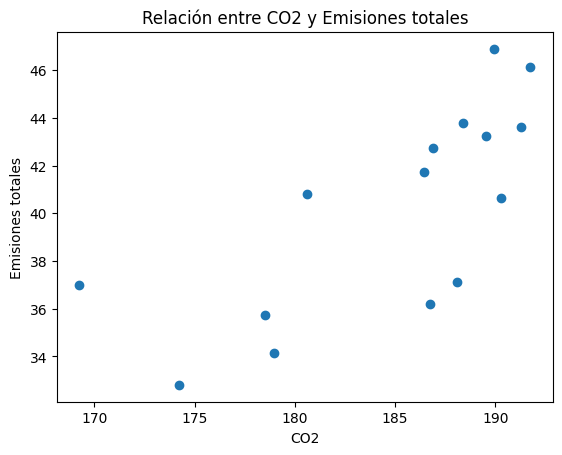

In [141]:
import matplotlib.pyplot as plt

plt.scatter(df_completo['co2'], df_completo['e_emisiones totales'])
plt.xlabel('CO2')
plt.ylabel('Emisiones totales')
plt.title('Relación entre CO2 y Emisiones totales')
plt.show()


Selecciono solo las variables relevantes para el modelo y a partir de ahi aplico feauter seleccion

In [123]:
variables_modelo = ['year', 'population','ep_total', 'pib', 'consumo_tot', 'consumo_pr', 'consumo_pu', 'inversion']
df_completo_modelo=df_completo.filter(variables_modelo)
df_completo_modelo[variables_modelo] = df_completo_modelo[variables_modelo].interpolate(method='nearest')
df_completo_modelo = df_completo_modelo[df_completo_modelo['year'] >= 1993]

In [124]:
import statsmodels.api as sm

### Cuales son las variables relevantes al 5%?

In [125]:
data=df_completo_modelo.drop("ep_total", axis=1)
target=df_completo_modelo["ep_total"]

In [126]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [127]:
def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [128]:
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [129]:
stepwise_selection(data,target)

['pib', 'consumo_tot']

In [130]:
backward_elimination(data, target,significance_level = 0.05)

['year', 'population', 'consumo_tot', 'consumo_pr', 'consumo_pu', 'inversion']

In [131]:
forward_selection(data, target, significance_level=0.05)

['pib', 'consumo_tot']

### Como queda nuestro modelo?

Usando stepwise y fordward selection, las variables mas significativas para explicar las emisiones "ep_total" son la el pib y el consumo total. 

Si comenzamos aplicando una regresion lineal, nuestro modelo es sencillo, pero ambas variables parecen ser significativas (p-valor bajo) al mismo tiempo que el R2 del modelo es elevado (0,96). Vemos que hay un mejor desempeño en el conjunto de prueba respecto del conjunto de entrenamiento, lo que nos daria señales de que el modelo ajusta bien (aunque seria oportuno testear si este modelo sirve tambien para otros paises por ejemplo, de forma que el pib y el consumo total realmente sirvan como predictores de las emisiones de la electricidad). 

De esta manera, como asesores de una empresa energetica como YPF, lograriamos estimar las emisiones para los proximos años a traves de proyecciones del PIB argentino y del consumo total. 

In [132]:
data_selected = ['pib','consumo_tot']
data2=data.filter(data_selected)

In [133]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data2,target,test_size=0.2,random_state=2)
from sklearn.linear_model import LinearRegression

#modelo
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [134]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Coeficientes del modelo
print("Coeficientes:")
for feature, coef in zip(X_train.columns, lr.coef_):
    print(f"{feature}: {coef}")

print("Intercepto:", lr.intercept_)

# Métricas de evaluación
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("Error cuadrático medio (MSE) en entrenamiento:", mean_squared_error(y_train, y_pred_train))
print("Error cuadrático medio (MSE) en prueba:", mean_squared_error(y_test, y_pred_test))

print("Coeficiente de determinación (R^2) en entrenamiento:", r2_score(y_train, y_pred_train))
print("Coeficiente de determinación (R^2) en prueba:", r2_score(y_test, y_pred_test))


Coeficientes:
pib: 0.00010055512375965286
consumo_tot: -1.0369347626104127e-06
Intercepto: 10.915214102389502
Error cuadrático medio (MSE) en entrenamiento: 4.201309124633974
Error cuadrático medio (MSE) en prueba: 1.889898497959272
Coeficiente de determinación (R^2) en entrenamiento: 0.856265721550659
Coeficiente de determinación (R^2) en prueba: 0.9614800830973061
